# **Importing required libraries**

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# **Dataset loading**

In [3]:
# Loading Dataset
df = pd.read_csv("online_retail_II.csv", encoding="ISO-8859-1")  # Correct encoding


In [4]:
# Cleaning
df = df.drop_duplicates()  # Removing duplicates
df = df.dropna(subset=["Customer ID"])  # Removing missing customers

df["InvoiceDate"] = pd.to_datetime(
    df["InvoiceDate"],
    dayfirst=True,
    errors="coerce"
)  # Converting dates

df = df.dropna(subset=["InvoiceDate"])  # Droping invalid dates
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]  # Removing returns & invalid prices

df["TotalPrice"] = df["Quantity"] * df["Price"]  # Transaction-level spend

# **Step 1: Unit of Analysis**

In [5]:
# Unit of Analysis
customer_df = df.groupby("Customer ID").agg(
    TotalSpend=("TotalPrice", "sum"),            # Monetary value
    TotalTransactions=("Invoice", "nunique"),   # Purchase frequency
    TotalQuantity=("Quantity", "sum"),          # Volume purchased
    AvgBasketValue=("TotalPrice", "mean"),      # Average spend per line
    DistinctProducts=("StockCode", "nunique"),  # Product diversity
    FirstPurchase=("InvoiceDate", "min"),
    LastPurchase=("InvoiceDate", "max")
).reset_index()

## **Analysis of Clustering**
The clustering effectiveness relies on the choice of an analytical entity that is stable in behaviour, has measurably varying, and is interpretively relevant. Transactional retail datasets are data sets that have non-homogeneous records of purchases, returns and adjustments. Analytical coherence then demands aggregation to a unit that can capture long-term patterns and not single events. The objectives of structural discovery are on behavioural differentiation; the unit is, therefore, required to support feature construction that captures meaningful variance and also prevents the noise generated through transactional volatility.
## **Explanation of  choice**
The analytical unit of customer-level clustering is chosen after considering customers, invoices, transactions, and products. Invoice level clustering captures the characteristics of the baskets but does not have behavioural continuity. Transaction level clustering creates too much granularity and noise, lowering the stability of the structure. Clustering at product level is a product-based demand and not behavioural variance. Customer aggregation forms repeat interactions into behaviourally consistent objects, allowing to build meaningful indicators that express the intensity, frequency, recency and diversity of engagement. This representation maintains structural variance without much transactional volatility such that similarity relationship depicts consistent behavioural patterns. Customer level segmentation offers the most consistent, consistent and interpretable clustering form.
## **Justification of the unit segmentation**
Customer level segmentation would offer a predictable and stable platform on which the segmentation could be clustered as customer behaviour is an indicator of repeated buying behaviour and not one-off purchases. Aggregated customer characteristics distinguish significant distinctions in spending, frequency, recency and product variety. This solution minimizes the variations that arise due to a single invoice or fluctuation of the line items. Similarity relationships are thus consistent behavioural traits rather than short term transactional impacts. The resultant clusters of customer segmentation are therefore interpretable and accurate reflection of real behavioural difference, which maintains structural coherence and valid comparison of segments within the analysis of the cluster.


# **Step 2: Feature Construction**

In [6]:
# Feature Engineering
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

customer_df["Recency"] = (
    snapshot_date - customer_df["LastPurchase"]
).dt.days  # Days since last purchase

customer_df["CustomerLifespan"] = (
    customer_df["LastPurchase"] - customer_df["FirstPurchase"]
).dt.days  # Active duration

# Selecting numeric clustering features
features = customer_df[[
    "TotalSpend",
    "TotalTransactions",
    "TotalQuantity",
    "AvgBasketValue",
    "DistinctProducts",
    "Recency",
    "CustomerLifespan"
]]

## **Construction of the features**
Construction of features has been done by customer-level aggregation of the analytical environment. The grouped calculations were done on the basis of Customer ID to transform transactional records. The cumulative monetary value calculated as the product of Quantity and Price has been calculated as TotalSpend. The number of unique Invoice identifiers which are used to represent purchasing frequency, is used to calculate TotalTransactions. AvgBasketValue is computed by means of transaction-level values of TotalPrice. The operationalisation of recency had been as the days between the last purchase and the reference date of the dataset. DistinctProducts has been gauged by the number of different values of StockCode, which reflects the breadth of behaviour. These properties were produced with deterministic aggregation functions that have been numerically consistent and compatible with distance-based clustering algorithms.
## **Reflection on the behavioural unit**
### ***Total spend***
It measures the intensity of economic participation and separates consumers according to value creation tendencies. TotalTransactions is a measure of the repetition dynamics of behavioural regularity of purchasing interactions. The latter is what sets the sporadic purchasing behaviour in comparison to regular engagement structures.
### ***Avg basket value***
AvgBasketValue is measuring expenditure concentration over a transaction, which operationalises purchasing intensity. This measure makes a distinction between high-frequency low-value purchasing and low-frequency high-value purchasing behaviour. Recency is used to measure the inactivity duration by counting the time taken since the latest purchase. This variable is the measure of behavioural continuity and the persistence of engagement.
### ***Distinct Products***
DistinctProducts purchases diversity is gauged by the number of product identifiers. This aspect captures the breadth of behaviour, which separates concentrated purchasing behaviour and diversified styles of consumption.


# **Step 3: Scaling**

In [7]:
# Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)  # Standardisation

## **Necessity of scaling**
Clustering methods run on distance calculations, in which similarity relationships are calculated through geometric proximity between the feature space. Customer-constructed behavioural features have heterogeneous numerical magnitudes such as monetary values, counts of frequencies and times. Lack of scaling would skew the distance structure where variables with high magnitude would prevail in similarity calculations regardless of their relevance to behaviour. Scaling thus provides that every feature adds value to the geometry of clustering, maintaining multidimensional behavioural variance and avoiding magnitude-driven bias. Distance-based segmentation, structural validity would be observed by balanced variance representation.
## **Used method**
The scale feature has been done by the standardisation process that has been done by using z-score transformation in the analysis environment. The approach scales up or down each feature by classifying the difference between the mean and the standard deviation, thus leading to the zero mean and unit variance of the variables. Through standardisation, relative distributional properties are maintained yet comparability is maintained even when the behavioural indicators are heterogeneous. The chosen strategy is mathematically consistent with the distance metrics based on Euclidean distance used by K-means and allows conducting a stable analysis of similarity between features that vary in the measurement scale.
## **Impact of feature scaling selection**
Scaling is a direct definition of clustering geometry, which is the variance weighting of features. Standardisation also avoids effects of dominance that are caused by large-magnitude variables like TotalSpend to ensure equal contribution made by frequency, intensity, temporal, and diversity indicators. Representation coherence thus helps clusters to capture behavioural heterogeneity as opposed to numerical scale differences.


# **Step 4: Applying Clustering**

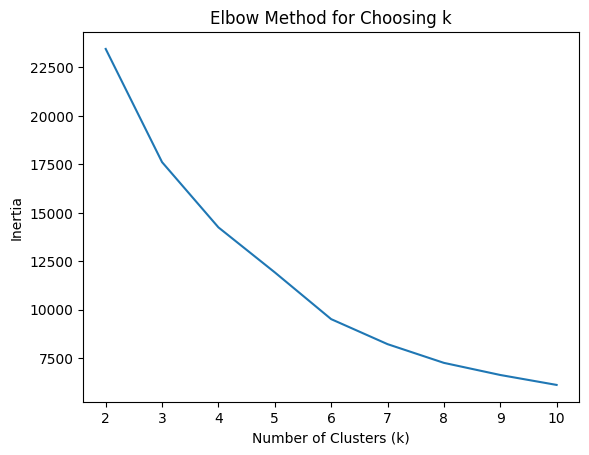

In [8]:
# Elbow Method
inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(K_range, inertia)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Choosing k")
plt.show()

In [9]:
# Apply K-Means
optimal_k = 4  # Choosing based on elbow and interpretability
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

customer_df["Cluster"] = kmeans.fit_predict(scaled_features)

# Silhouette
print("Silhouette Score:",
      round(silhouette_score(scaled_features,
                             customer_df["Cluster"]), 4))

Silhouette Score: 0.3906


In [10]:
# Inspecting Cluster Sizes
print("\nCluster Sizes:")
print(customer_df["Cluster"].value_counts())

# Comparing Cluster Centres
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_profile = pd.DataFrame(cluster_centers,
                               columns=features.columns)
cluster_profile["Cluster"] = range(optimal_k)

print("\nCluster Profiles (Original Scale):")
print(cluster_profile)


Cluster Sizes:
Cluster
1    2466
2    1826
0      18
3       2
Name: count, dtype: int64

Cluster Profiles (Original Scale):
     TotalSpend  TotalTransactions  TotalQuantity  AvgBasketValue  \
0  97828.275556          87.777778   68640.833333      177.101013   
1    583.362069           1.721205     341.844933       34.164797   
2   3040.400185           7.302997    1876.908447       29.723064   
3  12434.920000           1.500000       1.500000     8955.835000   

   DistinctProducts     Recency  CustomerLifespan  Cluster  
0        610.333333   20.000000        345.500000        0  
1         29.393569  134.536834         33.147334        1  
2        104.214714   33.617439        267.106267        2  
3          1.000000  264.000000          0.000000        3  


## **Parameter choice**
The specification of parameters in clustering analysis must be analytically justified explicitly so as to maintain structural validity and interpretive reliability. The algorithms of clustering are extremely sensitive to the parameter settings, and the improper choice leads to the direct distortion of the similarity geometry and segmentation results. The size of clusters in K-means is thus calculated by logical assessment and not randomly. The elbow method has been used to determine the patterns of inertia reduction over candidate values of k and allowed establishing diminishing marginal improvements in within-cluster variance. It is a process that guarantees that the structure of clusters reflects representational variance as opposed to heuristic preference.
## **Arbitrary decisions**
Evading arbitrary choices is a crucial principle of modelling unsupervised learning. Lack of ground truth labels erases external benchmarks on validation and relies more on representational coherence and defensibility of parameters. Analytical arguments were then used in the selection of algorithms, scaling of features and parameter specification. The modelling decisions were made by sympathising each method with the characteristics of the dataset, distance assumptions and geometry of the behaviour features. Justification of parameters is then seen as a way of checking structural bias, reproducibility and maintaining interpretative consistency.


# **Step 5: Evaluation and Interpretation**

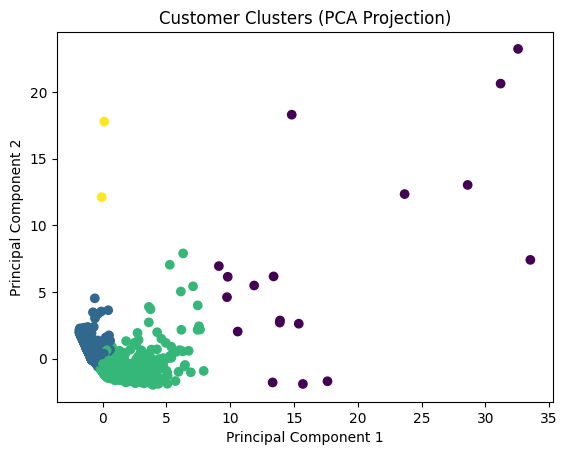

In [11]:
# PCA Visualisation
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

plt.figure()
plt.scatter(components[:, 0],
            components[:, 1],
            c=customer_df["Cluster"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Clusters (PCA Projection)")
plt.show()

## **Distinctive characteristic of each cluster**
The clusters are differentiated in terms of Total Spend, Transaction Frequency, Recency and Product Diversity. One huge segment is with low expenditure and minimal dealings, which means low involvement. The other significant group has been seen as the medium spenders and continuous shoppers, indicating recurrent activity. A smaller segment is high-value customers who have high overall expenditure and a wide product range. The small group is defined as a high average basket value with a low frequency of transactions, which means concentrated buying behaviour.
## **Appearances of balanced clusters**
The largest two clusters are holding most customers, and the other two smaller clusters take up more specialised behavioural patterns. This distribution gives structured variation in the buying behaviour among the customers. The presence of both dominant and niche segments indicates differentiated customer intensity levels within the dataset.
## **Limitations of the approach**
A clustering structure is based on chosen numerical features and depends upon the scaling method and distance metric. The interpretation is thus founded on the quantitative purchasing indicators. The model assumes a spherical cluster structure, which shapes how behavioural similarity is defined.
## **Parameter choices sensitivity**
The final step, segmentation, is based on the number of clusters and scaling of features chosen. The chosen configuration is supported by the Elbow Method and Silhouette Score, which shows that the solution of the clustering is stable. The PCA projection further confirms visible separation under the selected parameter setting.


# **Bibliography**
* Collentine, J.O., 2024. Well-reasoned and arbitrary decisions:: Investigating how and why research outcomes vary in psychology. https://pure.uvt.nl/ws/portalfiles/portal/87590753/Olsson_Collentine_Well-Reasoned_09-02-2024.pdf
* Creel, K. and Hellman, D., 2022. The algorithmic leviathan: Arbitrariness, fairness, and opportunity in algorithmic decision-making systems. Canadian Journal of Philosophy, 52(1), pp.26-43. https://www.cambridge.org/core/services/aop-cambridge-core/content/view/3AA0ECA77F8622488E9DB0834287215B/S0045509122000030a.pdf/div-class-title-the-algorithmic-leviathan-arbitrariness-fairness-and-opportunity-in-algorithmic-decision-making-systems-div.pdf
* Lacko, D., Čeněk, J., Točík, J., Avsec, A., Đorđević, V., Genc, A., Haka, F., Šakotić-Kurbalija, J., Mohorić, T., Neziri, I. and Subotić, S., 2022. The necessity of testing measurement invariance in cross-cultural research: Potential bias in cross-cultural comparisons with individualism–collectivism self-report scales. Cross-Cultural Research, 56(2-3), pp.228-267.https://osf.io/preprints/psyarxiv/9ytj3/download/
* Nie, F., Li, Z., Wang, R. and Li, X., 2022. An effective and efficient algorithm for K-means clustering with new formulation. IEEE Transactions on Knowledge and Data Engineering, 35(4), pp.3433-3443. https://ieeexplore.ieee.org/iel8/6287639/6514899/10829579.pdf